In [1]:
import time
start_time=time.time()

In [2]:
#import sys
#from pathlib import Path
import json
import numpy as np
#import strucfunc
import matplotlib.pyplot as plt
import time
#from astropy.io import fits
import pandas as pd
import seaborn as sns
#import math
#import sys
#import os
#from sabreMod import sosf,sosfh
#from scipy import interpolate
#import itertools
import lmfit

In [3]:
def bfunc00(r, r0, sig2, m):
    "Simple 3-parameter structure function"
    C = 1.0 / (1.0 + (r / r0)**m)
    return 2.0 * sig2 * (1.0 - C)

In [4]:
def bfunc01(r, r0, sig2, m, s0):
    "Structure function with added seeing (scale `s0`)"
    seeing = (np.tanh((r / (2.0 * s0)**2)))**2
    return seeing * bfunc00(r, r0, sig2, m)

In [5]:
data = json.load(open("SFdata//30Dor.json"))

pixscale = 0.2 # arcsec
pixscale *= 0.242               # parsec
s0 = 0.242*.92              # parsec
m = 1.22


2.7217771927917216

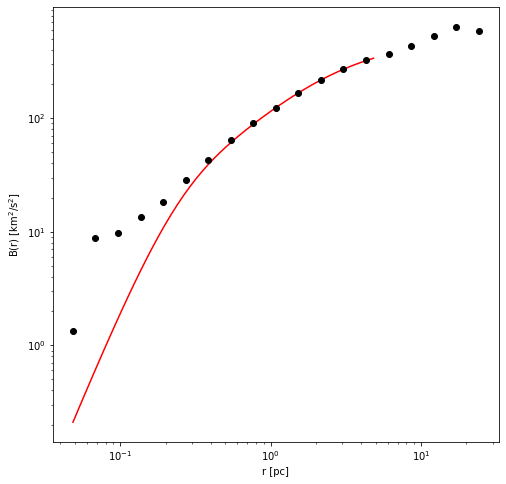

In [6]:

r = pixscale * 10**np.array(data["log10 r"])
B = np.array(data["Unweighted B(r)"])
sig2 = data["Unweighted sigma^2"]

rgrid = pixscale * np.logspace(0.0, 2)
r0 = np.interp(sig2, B, r)

fig, ax = plt.subplots(figsize=(8, 8))
# Plot fit to unweighted strucfunc
ax.plot(rgrid, bfunc01(rgrid, r0, sig2, m, s0), color="red")
# Plot points from unweighted strucfunc
ax.plot(r, B, 'o',  color='black')

ax.set(
    xscale = "log",
    yscale = "log",
#    ylim  = [1, 250],
#    xlim  = [1, 150],
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
)

r0

In [7]:
model01 = lmfit.Model(bfunc01)
model01.param_names

['r0', 'sig2', 'm', 's0']

In [8]:
relative_uncertainty = 0.1
weights = 1.0 / (relative_uncertainty * B)
weights[0] /= 8.0
weights[1] /= 6.0
weights[2] /= 4.0

In [9]:
for p in model01.param_names:
    model01.set_param_hint(p, min=0.0)
model01.print_param_hints()

Name     Value      Min      Max     Vary    Expr    
m          nan        0      inf     True    
r0         nan        0      inf     True    
s0         nan        0      inf     True    
sig2       nan        0      inf     True    


In [10]:
result2 = model01.fit(
    B, 
    weights=weights,
    r=r, r0=r0, sig2=sig2, m=m, s0=s0
)

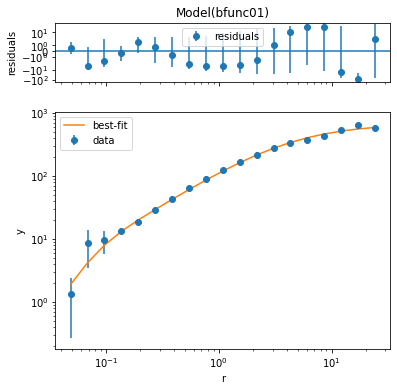

In [11]:
fig, _ = result2.plot()
fig.axes[0].set(
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale="log",
    yscale="log",
);



In [12]:
print(result2.fit_report())

[[Model]]
    Model(bfunc01)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 19
    # variables        = 4
    chi-square         = 5.96275392
    reduced chi-square = 0.39751693
    Akaike info crit   = -14.0192242
    Bayesian info crit = -10.2414683
[[Variables]]
    r0:    4.20913500 +/- 0.47502682 (11.29%) (init = 2.721777)
    sig2:  334.198002 +/- 18.9688016 (5.68%) (init = 252.1136)
    m:     1.12469209 +/- 0.03263080 (2.90%) (init = 1.22)
    s0:    0.12331932 +/- 0.01420754 (11.52%) (init = 0.22264)
[[Correlations]] (unreported correlations are < 0.100)
    C(r0, sig2) =  0.933
    C(r0, m)    = -0.900
    C(sig2, m)  = -0.745
    C(m, s0)    = -0.517
    C(r0, s0)   =  0.363
    C(sig2, s0) =  0.298


In [13]:
result2.conf_interval()
print(result2.ci_report())

         99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0  :  -1.31400  -0.88842  -0.46384   4.20914  +0.56972  +1.38512  +2.83786
 sig2: -59.67041 -38.54275 -19.31166 334.19800 +21.72036 +49.69294 +92.74897
 m   :  -0.13415  -0.07662  -0.03489   1.12469  +0.03383  +0.07114  +0.11738
 s0  :  -0.05755  -0.02773  -0.01322   0.12332  +0.01388  +0.02925  +0.04722


In [14]:
sig2

252.11363212022405

In [15]:
lmxsig2=220
lmnsig2=480
lmxr0=2
lmnr0=9
lmxm=0.9
lmnm=1.3
lmxs0=0.0
lmns0=0.5

lmxsig2=sig2*2
lmnsig2=sig2*0.25
lmxr0=r0*2
lmnr0=r0*0.25
lmxm=m*2
lmnm=m*0.25
lmxs0=s0*2
lmns0=s0*0.25

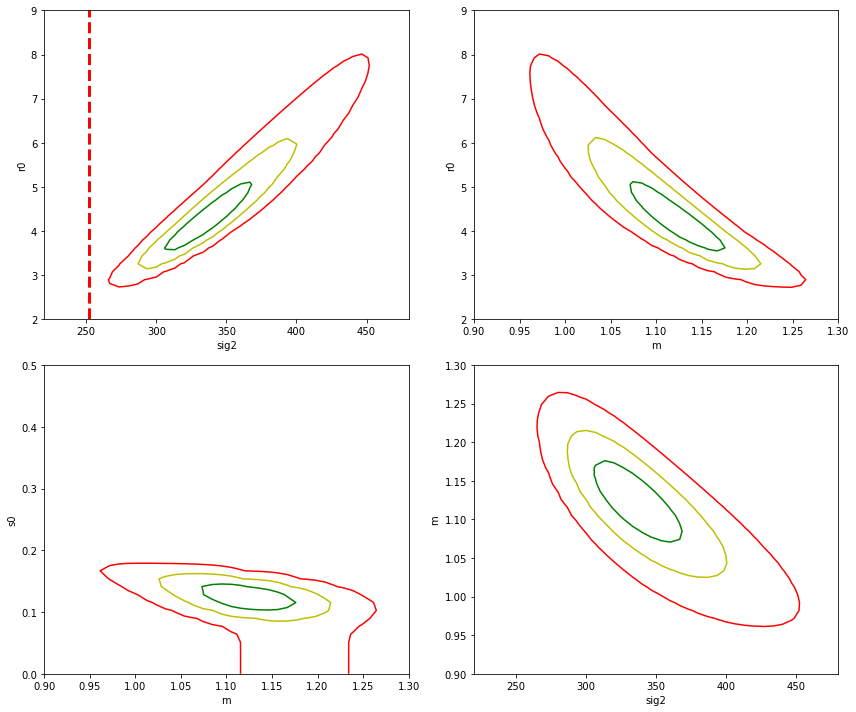

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
cx, cy, grid = lmfit.conf_interval2d(
    result2, result2, 'sig2', 'r0', 40, 40,
    limits=[[lmnsig2, lmxsig2], [lmnr0, lmxr0]],
)
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]
ctp = axes[0, 0].contour(cx, cy, grid, levels, colors=colors)
axes[0, 0].axvline(result2.init_params["sig2"].value, color="r", lw=3, ls="dashed")
axes[0, 0].set_xlabel('sig2')
axes[0, 0].set_ylabel('r0')

cx, cy, grid = lmfit.conf_interval2d(
    result2, result2, 'm', 'r0', 40, 40,
    limits=[[lmnm, lmxm], [lmnr0, lmxr0]],
)
ctp = axes[0, 1].contour(cx, cy, grid, levels, colors=colors)
axes[0, 1].set_xlabel('m')
axes[0, 1].set_ylabel('r0')

cx, cy, grid = lmfit.conf_interval2d(
    result2, result2, 'm', 's0', 40, 40,
    limits=[[lmnm, lmxm], [lmns0, lmxs0]],
)
ctp = axes[1, 0].contour(cx, cy, grid, levels, colors=colors)
axes[1, 0].set_xlabel('m')
axes[1, 0].set_ylabel('s0')

cx, cy, grid = lmfit.conf_interval2d(
    result2, result2, 'sig2', 'm', 40, 40,
    limits=[[lmnsig2, lmxsig2], [lmnm, lmxm]],
)
ctp = axes[1, 1].contour(cx, cy, grid, levels, colors=colors)
axes[1, 1].set_xlabel('sig2')
axes[1, 1].set_ylabel('m')

fig.tight_layout();

In [17]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 39.15814757347107 seconds ---
